In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *

In [3]:
from fastai.vision import *

In [4]:
from io import StringIO
import numpy as np
import os
from PIL import Image
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline

In [5]:
from PIL import Image, ImageChops, ImageEnhance
import sys, os.path

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

In [6]:
import torch
torch.cuda.set_device(1)

path = '/home/FRACTAL/jitesh.arora/TRI_HACKATHON/Stage3/fakers/stage-3/stage3_image_data'

In [7]:
class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9,sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        #self.metric = res.mean()
        self.metric = res     



## Looking at the data

For the task of Real versus Fake classification,  I have converted Images to ELA images. As we where able to explore from initial EDA analysis ELA provides sharper boundary for counterfeit images.  This is helpful to huma eyes as well also model is providing better results.

I have used codes from : https://gist.github.com/ewencp/3356622 to create new Train and Test dataset with ELA of images.

In [8]:

name = 'resnet101_ela'
new_path = path

In [9]:

SEED =12
SZ =224
BS = 8
NUM_WORKERS = 8

data =   (ImageItemList.from_folder(f'{new_path}/train_ela')
        .random_split_by_pct( 0.2 , seed = 12 )
        .label_from_folder()
        .add_test(ImageItemList.from_folder(f'{new_path}/test_ela'))
        .transform(get_transforms(do_flip=True , max_zoom=1.1), size=SZ, resize_method=ResizeMethod.CROP)
        .databunch(bs = BS , num_workers = NUM_WORKERS, path = new_path)).normalize(imagenet_stats)

#ImageDataBunch.from_folder(path, valid_pct = 0.2, ds_tfms=tfms, size=112)


In [10]:
print(len(data.train_ds))
print(len(data.valid_ds))

25808
6451


In [11]:
print('train real images pct' , data.train_ds.y.items.mean())
print('valid real images pct' , data.valid_ds.y.items.mean())

train real images pct 0.2596094234345939
valid real images pct 0.2593396372655402


In [15]:
print(data.classes)
len(data.classes),data.c

['fake', 'real']


(2, 2)

## Training: resnet101

In [16]:
from fastai.metrics import accuracy
#acc_02 = partial(accuracy_thresh, thresh=0.5)
f1 = fbeta_binary()  # default is F1


In [17]:
learn = create_cnn(data, models.resnet101,  lin_ftrs =[2048] ,metrics=[error_rate , f1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


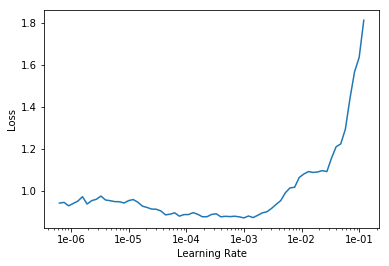

In [17]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.freeze_to(-1)
learn.fit_one_cycle(5, 2e-4)
learn.save(f'{name}-stage1');
learn.recorder.plot_losses()

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.458258,0.431111,0.200744,0.538324
2,0.435073,0.419915,0.196714,0.589719
3,0.408279,0.415128,0.196249,0.577154


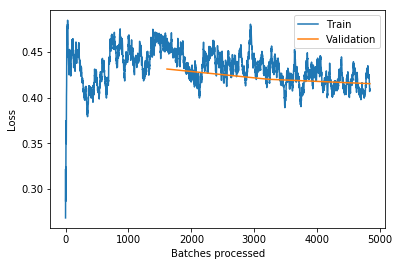

In [22]:
learn.freeze_to(-1)
learn.load(f'{name}-stage1');
learn.fit_one_cycle(3 , 2e-4);
learn.recorder.plot_losses();

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.401199,0.423159,0.197644,0.559281
2,0.471376,0.424631,0.195784,0.596615
3,0.455312,0.427184,0.198729,0.561259
4,0.447218,0.420928,0.194698,0.577957
5,0.420739,0.436510,0.197489,0.494845
6,0.416969,0.427261,0.199504,0.553280
7,0.404928,0.413200,0.188653,0.607293
8,0.402237,0.405240,0.188188,0.594251
9,0.397438,0.407741,0.187723,0.591293
10,0.407206,0.405665,0.189583,0.571929


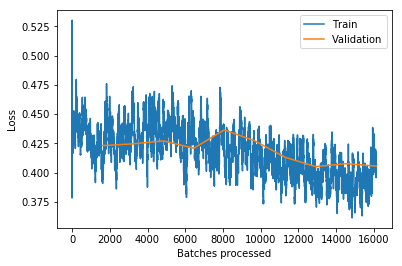

In [26]:
learn.freeze_to(-1)
learn.load(f'{name}-stage1');
learn.freeze_to(-1);
learn.fit_one_cycle(10 , 2e-4);
learn.recorder.plot_losses();
learn.save(f'{name}-stage1-5');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


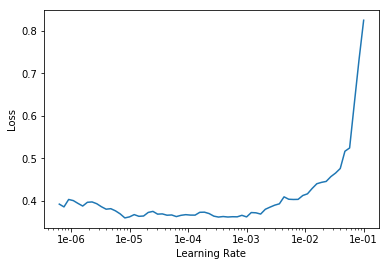

In [27]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.load(f'{name}-stage1-5');
learn.unfreeze()
max_lr =2e-4
lrs = [max_lr/100 , max_lr/10 , max_lr ]
learn.fit_one_cycle( 16, lrs)
learn.save(f'{name}-stage2');

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.439033,0.411018,0.186793,0.604529
2,0.441321,0.409425,0.189583,0.577548
3,0.432703,0.439892,0.193613,0.529567
4,0.447242,0.424139,0.199039,0.508046
5,0.446102,0.409960,0.184468,0.596610
6,0.407115,0.411940,0.180437,0.616601
7,0.410656,0.473130,0.220741,0.552201
8,0.418687,0.413439,0.187258,0.622736
9,0.407252,0.428820,0.195319,0.542816
10,0.388119,0.430606,0.185088,0.620229


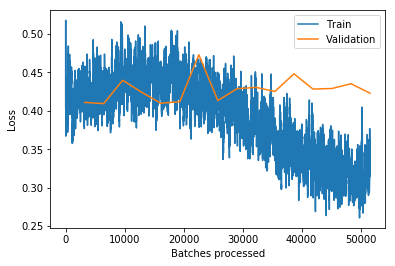

In [19]:
learn.recorder.plot_losses();

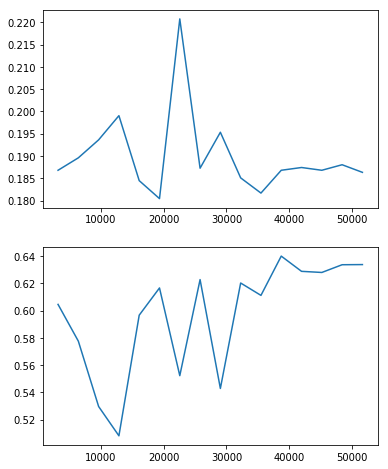

In [61]:
learn.recorder.plot_metrics();

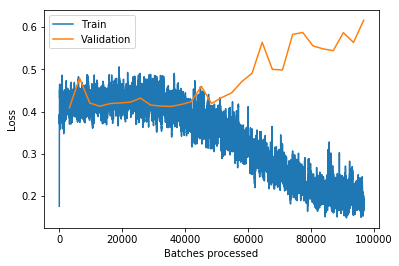

In [20]:
learn.recorder.plot_losses();

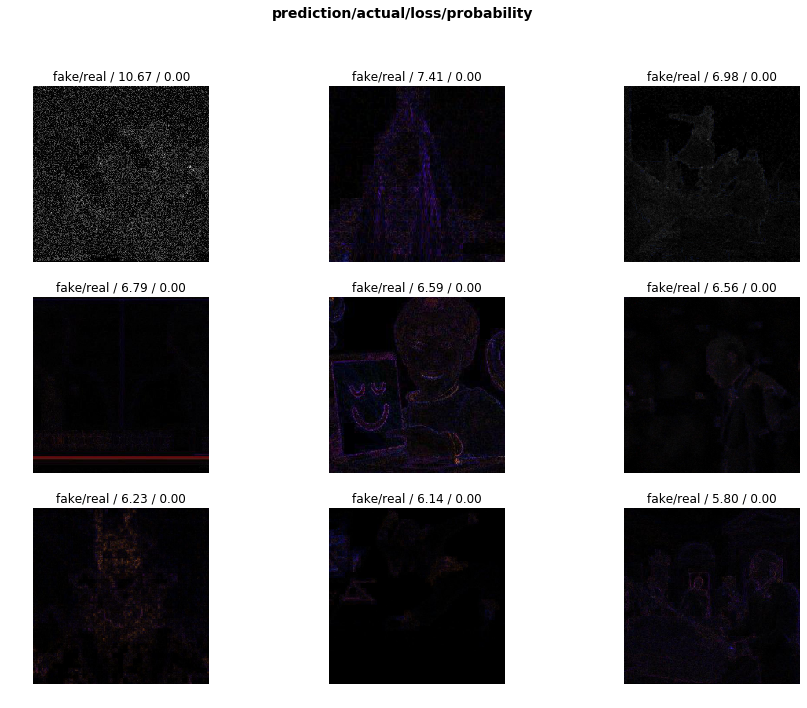

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.train_ds)==len(losses)==len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

In [21]:
tl_val,tl_idx = interp.top_losses(9,True)

Looking at one of the high loss images. As we can see that this image has some animated part present in it. But challenge tells that this is a real image. 


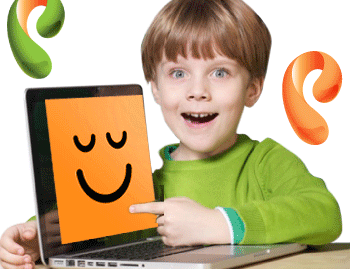

In [58]:
PIL.Image.open(fname)

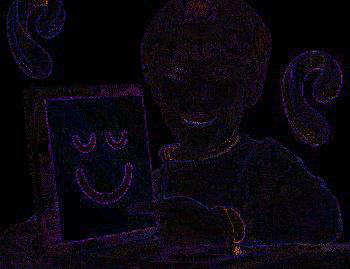

In [59]:
"""
ELA plot of same image
"""
PIL.Image.open(fname)

Confusion matrix for model trained on images sized (224 , 224)

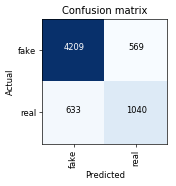

In [60]:
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

### Training on bigger size

In [9]:
SEED =12

SZ =224*2
BS = 8
NUM_WORKERS = 24


data =   (ImageItemList.from_folder(f'{new_path}/train_ela')
        .random_split_by_pct( 0.2 , seed = 12 )
        .label_from_folder()
        .add_test(ImageItemList.from_folder(f'{new_path}/test_ela'))
        .transform(get_transforms(do_flip=True , max_zoom=1.1), size=SZ, resize_method=ResizeMethod.CROP)
        .databunch(bs = BS , num_workers = NUM_WORKERS, path = new_path)).normalize(imagenet_stats)

In [10]:

f1 = fbeta_binary()
learn = create_cnn(data, models.resnet101,  lin_ftrs =[2048] ,metrics=[error_rate , f1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


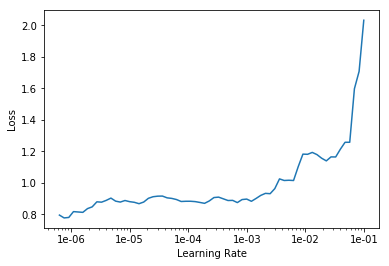

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.data.batch_size = 16

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.373216,0.412562,0.187103,0.614992
2,0.377147,0.418456,0.183537,0.638584
3,0.368770,0.394466,0.176097,0.630929
4,0.376125,0.388434,0.169741,0.651828
5,0.371681,0.384735,0.172531,0.637341
6,0.346428,0.382928,0.169431,0.636273
7,0.367128,0.382741,0.171136,0.644788
8,0.351359,0.383969,0.170826,0.642903


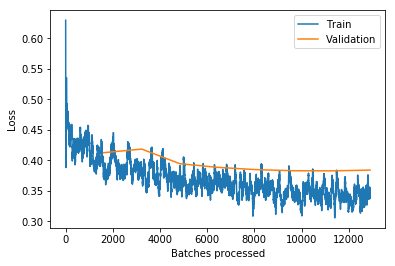

In [13]:
#learn.clip_grad();
learn.load(f'{name}-stage2');

learn.freeze_to(-1)
learn.fit_one_cycle(8, 1e-4)

learn.save(f'{name}-stage3');
learn.recorder.plot_losses();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


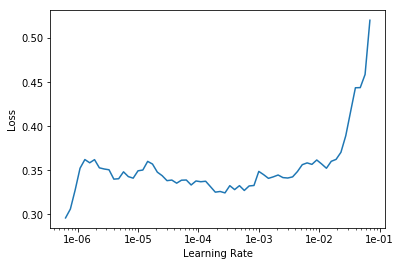

In [14]:
learn.lr_find();
learn.recorder.plot();

In [15]:
## remove clip_grap part

learn.unfreeze()
max_lr = 2e-4
lrs = [max_lr/100 , max_lr/10 , max_lr]
learn.fit_one_cycle(14 , lrs)
learn.save(f'{name}-stage4');

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.341944,0.385621,0.168811,0.644001
2,0.377986,0.390968,0.174702,0.668041
3,0.365706,0.391078,0.176252,0.653248
4,0.377216,0.397898,0.177957,0.629199
5,0.347673,0.396447,0.179507,0.580435
6,0.330132,0.395623,0.178732,0.607423
7,0.333019,0.405434,0.180127,0.581713
8,0.291648,0.426261,0.182762,0.641968
9,0.285842,0.415327,0.175787,0.618439
10,0.260129,0.429384,0.180127,0.640693


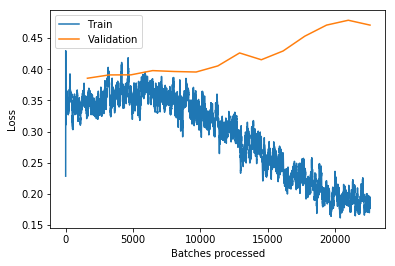

In [16]:
learn.recorder.plot_losses()

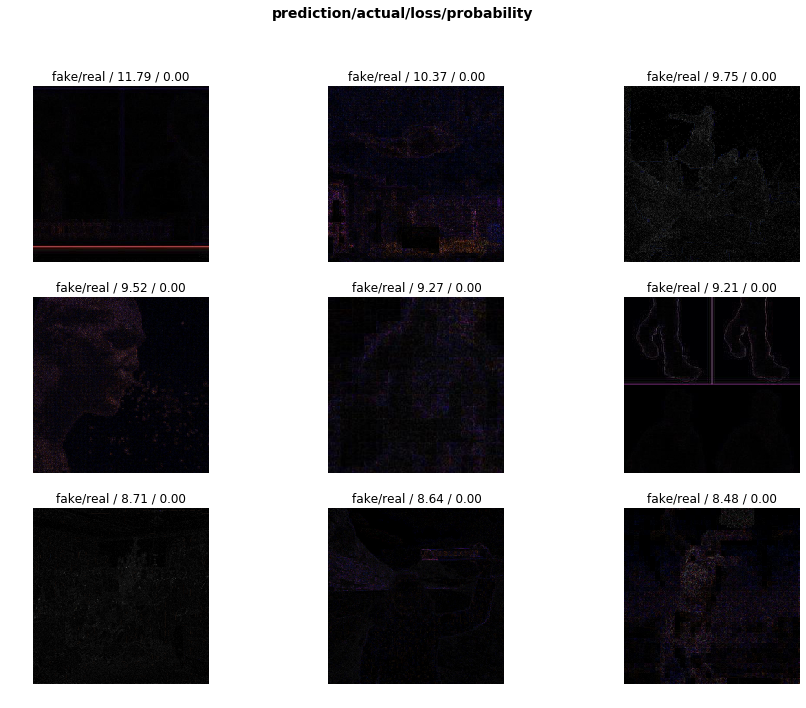

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.train_ds)==len(losses)==len(idxs)
tl_val,tl_idx = interp.top_losses(9,True)
interp.plot_top_losses(9, figsize=(15,11))


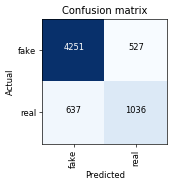

In [22]:
learn.save(f'{name}-stage4');
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

In [18]:
learn.wd = 0.1

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


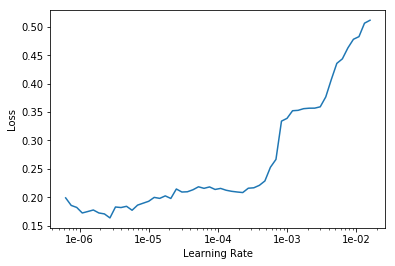

In [20]:
learn.recorder.plot()

In [23]:
f1 = fbeta_binary()
learn = create_cnn(data, models.resnet101,  lin_ftrs =[2048] ,metrics=[error_rate , f1] , wd = 0.1)
trn_label_cts = [len(data.train_ds.y.items) - data.train_ds.y.items.sum() ,data.train_ds.y.items.sum()]
total_size = len(data.train_ds)

trn_weights = [count/total_size for count in trn_label_cts]
#trn_weights = [0.6 , 0.4]
print(trn_weights)

from torch import nn

loss_weights = torch.FloatTensor(trn_weights).cuda()
learn.crit = partial( nn.CrossEntropyLoss() ,  weight = 1-loss_weights)

[0.7403905765654061, 0.2596094234345939]


In [24]:
learn.load(f'{name}-stage4');
learn.freeze_to(-1)
learn.fit_one_cycle(3, 1e-6)

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.188457,0.484915,0.186328,0.643957
2,0.182615,0.480519,0.177182,0.634474
3,0.196124,0.483606,0.178422,0.625447


In [ ]:
learn.recorder.plot_losses();

epoch,train_loss,valid_loss,error_rate,fbeta_binary
1,0.192173,0.474262,0.172996,0.648393
2,0.217564,0.475709,0.185243,0.646136
3,0.268735,0.471741,0.194854,0.609506
4,0.260148,0.461381,0.182762,0.630060
5,0.260222,0.434137,0.184157,0.643243
6,0.218138,0.474384,0.186483,0.595902
7,0.164484,0.530024,0.189583,0.639127
8,0.143286,0.523325,0.180747,0.634712
9,0.117032,0.541170,0.181677,0.638495
10,0.144629,0.547132,0.181057,0.635683


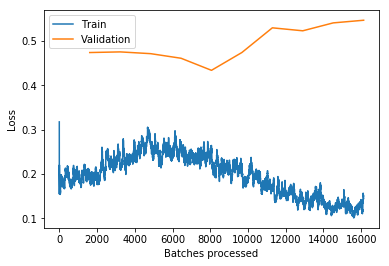

In [25]:
learn.unfreeze()
max_lr = 2e-4
lrs = [max_lr/100 , max_lr/10 , max_lr]
learn.fit_one_cycle(10 , lrs)
learn.save(f'{name}-stage5');
learn.recorder.plot_losses();

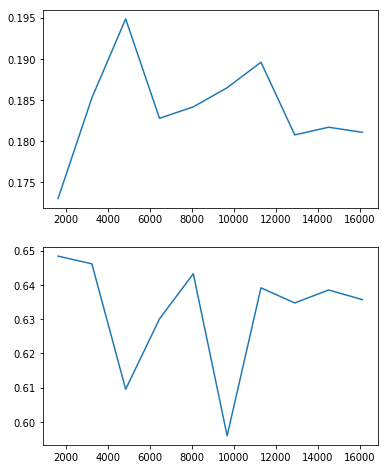

In [27]:
learn.recorder.plot_metrics()

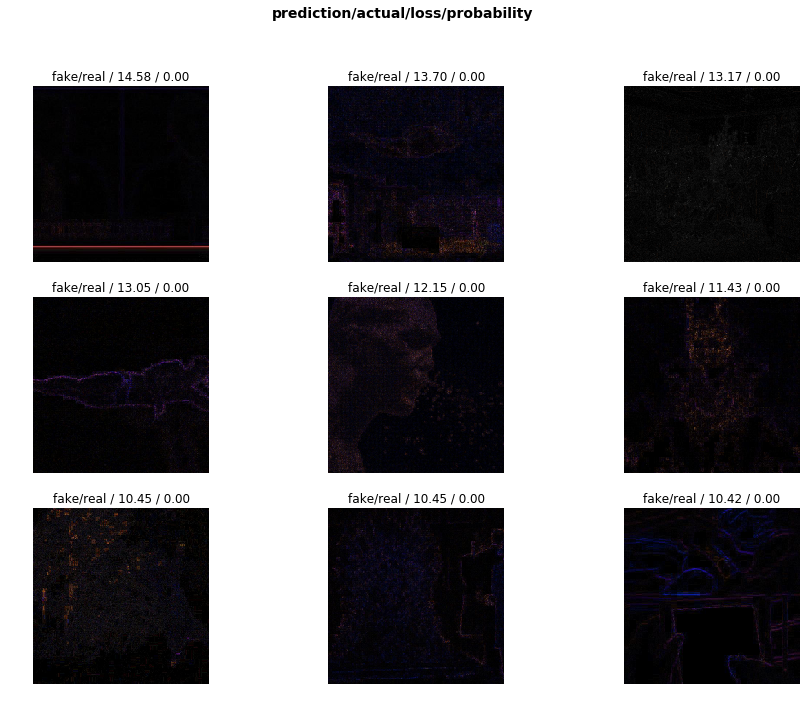

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.train_ds)==len(losses)==len(idxs)
tl_val,tl_idx = interp.top_losses(9,True)
interp.plot_top_losses(9, figsize=(15,11))

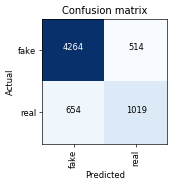

In [29]:
interp.plot_confusion_matrix(figsize=(3,3) ,dpi = 60)

Training for more epochs is not really helpful , F1 score is dropping a bit.

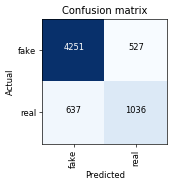

In [34]:
learn.load(f'{name}-stage4');
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(3,3), dpi=60)

# Get validation and  f1 score using optimal thresholding 


In [35]:
from sklearn.metrics import confusion_matrix, f1_score

In [36]:
val_pred , val_targs = learn.TTA(scale=1.30)
val_pred = val_pred.numpy()
val_targs = val_targs.numpy()
preds = np.argmax(val_pred , axis = 1)
print(f1_score(val_targs , preds , average='weighted'))

0.8263598755820025


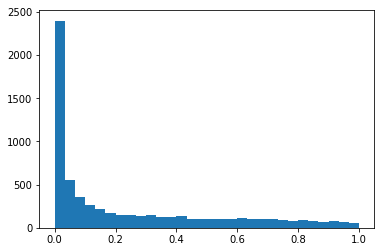

In [37]:
import matplotlib.pyplot as plt
plt.hist(val_pred[:, 1], bins=30);

find out optimal threshold to maximize TPRs of positve and negative class

In [44]:
fpr, tpr, thresholds = roc_curve(val_targs, val_pred[: ,1])
optimal_idx = np.argmax(np.abs(tpr - fpr))
optimal_threshold = thresholds[optimal_idx]


In [80]:
optimal_threshold

0.23901257

In [56]:
val_pred_opt=  np.where(val_pred[: , 1]> optimal_threshold  , 1, 0) #data['pred_proba'].map(lambda x: 1 if x > threshold else 0)
confusion_matrix(val_targs , val_pred_opt)

array([[3794,  984],
       [ 331, 1342]])

In [57]:
print('f1 score after optimal threshold' , f1_score(val_targs , val_pred_opt , average='weighted'))
print('f1 score mid threshold', f1_score(val_targs , preds , average='weighted'))

f1 score after optimal threshold 0.8053230009958818
f1 score mid threshold 0.8263598755820025


In [58]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(val_targs , val_pred_opt))
print(roc_auc_score(val_targs , preds))

0.7981039567433623
0.7496849352118709


# Get Test predictions

In [59]:
test_pred , _= learn.TTA(ds_type= DatasetType.Test , scale=1.30)  #
test_pred = test_pred.numpy()
test_label_y = np.argmax(test_pred , axis = 1)

In [66]:
cur_dir = os.getcwd()
test_groundtruth = pd.read_csv(f'{cur_dir}/data/stage3_ground_truth.csv')
test_groundtruth['Prediction'] = test_groundtruth['Prediction'].apply(lambda x: 1 if x=='real' else 0)

In [76]:
test_groundtruth.rename(columns={'Filename':'image_name'} , inplace=True)
test_groundtruth.head(2)

,image_name,Prediction
0,000626ee4bd468436ff39e7c7646393f.jpg,0
1,00145515d97132ea341d0d2ce817efc3.jpg,0


In [68]:
#preds_final = np.where(test_pred[:, 1]>=best_p, 1, 0)
submission_file = pd.DataFrame({'image_name': [path.name for path in learn.data.test_ds.x.items]})
submission_file['result']  = test_label_y
submission_file['score_c1']  = test_pred[ : , 1]

In [71]:
submission_file['image_name'] = submission_file['image_name'].apply(lambda x: str(x[:-8]))
submission_file.head(2)

,image_name,result,score_c1
0,test_elaf735a8a159d82deafb8c82c1e7ba04ea,0,0.193019
1,test_ela0657170be7fb5b0e4ec5930af6ebf05f,0,0.199217


In [72]:
submission_file['image_name'] = submission_file['image_name']+'.jpg'
submission_file['image_name'] = submission_file['image_name'].apply(lambda x: str(x[8:]))
submission_file.head(2)

,image_name,result,score_c1
0,f735a8a159d82deafb8c82c1e7ba04ea.jpg,0,0.193019
1,0657170be7fb5b0e4ec5930af6ebf05f.jpg,0,0.199217


In [77]:
merged_df = pd.merge(submission_file , test_truth , on = ['image_name'] , how = 'inner')


(5430, 4)


Because optimal threshold is maximising TPRs (Precisions) for two classes, it may or may not result in maximising the F1-score. But it is better to use above thresholding method because it is not dependent on distribution of Data in Validation set. 
If distribution of test data differs significantly from Test data then this thresholding will provide more balanced results.

In [81]:
merged_df['result_threshold'] = merged_df['score_c1'].apply(lambda x: 1 if x>optimal_threshold else 0)
f1_score(merged_df['Prediction'] , merged_df['result_threshold'] , average='weighted')

0.6672399221123707

In [79]:
f1_score(merged_df['Prediction'] , merged_df['result'] , average='weighted')

0.6344348355017053

Best F1 score using optimal thresolding is around 67% which is way below the F1 score for validation data. 
I will further try to fine tune the model to improve the results. 